<center> <h1>Continuous Control with Deep Reinforcement Learning</h1>
<h4>Timothy P. Lillicrap, Jonathan J. Hunt, Alexander Pritzel, Nicolas Heess, Tom Erez, Yuval Tassa, David Silver, Daan Wierstra<br />
http://arxiv.org/abs/1509.02971</h4>
<h4>Single pendulum example - Implemented by Yannis M. Assael </h4>
</center>

# Configuration

In [1]:
if itorch then
    arg = {}
end

cmd = torch.CmdLine()
cmd:text()
cmd:text('Options')

-- general options:
cmd:option('-seed', 1, 'initial random seed')
cmd:option('-threads', 8, 'number of threads')

-- gpu
cmd:option('-cuda', 0, 'cuda')

-- experiment
cmd:option('-action_size', 1, 'action dimensionality')
cmd:option('-action_lim', 10, 'action clipping')
cmd:option('-action_repeat', 3, 'frames in history')
cmd:option('-exploration_noise', 0.3, 'random exploration noise')
cmd:option('-episodes', 1000, 'number of episodes')
cmd:option('-episode_length', 30, 'frames of each episode')

-- model
cmd:option('-gamma', 0.99, 'discount factor')
cmd:option('-q_tau', 1e-2, 'soft target updates')
cmd:option('-dt', 0.1, 'time interval')
cmd:option('-img_size', 64, 'image size')
cmd:option('-batch_size', 16, 'batch training size')
cmd:option('-replay_buffer', 1e+6, 'replay buffer size')

-- training
cmd:option('-epochs_per_step', 1, 'epochs per step')
cmd:option('-l2_critic', 1e-2, 'l2 weight decay')
cmd:option('-l2_actor', 0, 'l2 weight decay')
cmd:option('-learningRate_actor', 1e-4, 'actor learning rate')
cmd:option('-learningRate_critic', 1e-3, 'critic learning rate')

-- get current path
require 'sys'
dname, fname = sys.fpath()
cmd:option('-save', dname, 'save path')
cmd:option('-load', 0, 'load pretrained model')

cmd:option('-plot', 0, 'display images')
cmd:text()

opt = cmd:parse(arg)

# Require

In [2]:
require 'hdf5'
require 'csvigo'
require 'image'
require 'nngraph'
require 'optim'
require 'nn'

log = require 'include.log'
tools = require 'include.base'
require 'include.dynamics'

require 'modules/LinearO'
require 'modules/GradientClipping'
require 'modules/GradientNormalization'

torch.manualSeed(opt.seed)
torch.setnumthreads(opt.threads)
torch.setdefaulttensortype('torch.FloatTensor')

In [3]:
-- Cuda initialisation
if opt.cuda > 0 then
    require 'cutorch'
    require 'cunn'
    require 'cudnn'
    cutorch.setDevice(opt.cuda)
    opt.dtype = 'torch.CudaTensor'
    print(cutorch.getDeviceProperties(opt.cuda))
else
    opt.dtype = 'torch.FloatTensor'
end

# Pendulum

In [4]:
game = {}
game.init_state = {0, 0} -- 1 angular velocity, 2 angle
game.target_state = {0, math.pi} -- 1 angular velocity, 2 angle

In [5]:
function game.control(s_t, a_t)
    -- Control input
    local f = {[1] = a_t * opt.action_lim}
    -- 1 angular velocity, 2 angle
    local s_t1 = control_sp(s_t, opt.dt, f)[1]
    -- Correct angle
    s_t1[2] = s_t1[2] % (2 * math.pi)
    return s_t1
end

In [6]:
function game.reward(s_t, a_t)
    -- distance reward
    local dist = (math.pi - math.abs(game.target_state[2] - (s_t[2] % (2*math.pi)))) / math.pi
    
    -- bonus reward if +-10 degrees
    local bonus = 0
    if dist > 1 - 0.174532925 / math.pi then
        bonus = 2
    end

    -- action cost
    local action = 0
    if a_t then
        action = - a_t:clone():abs():sum()*0.5
    end
    
    return dist + action + bonus
end

In [7]:
function game.generate_dataset(e)
    local data = {}

    -- Iterate episodes
    for episode = 1, e do
        
        -- Initialise Variables
        local s, x, a, r = {}, {}, {}, {}
        
        -- Receive initial observation state s_1    
        s[1], x[1] = {}, torch.Tensor(opt.action_repeat,opt.img_size,opt.img_size)
        for i = 1, opt.action_repeat do
            s[1][i] = tools.dc(game.init_state)
            x[1][i] = draw_sp(s[1][i][2], opt.img_size)
        end
        
        -- Run episode
        local err_episode = 0
        for t = 1, opt.episode_length do
            
            -- Pick random action
            a[t] = torch.randn(opt.action_size):mul(opt.exploration_noise):clamp(-1, 1)
            
            -- Execute action a_t and observe reward r_t and observe new state s_{t+1}
            s[t+1], x[t+1] = {}, torch.Tensor(opt.action_repeat,opt.img_size,opt.img_size)
            
            s[t+1][1] = game.control(s[t][opt.action_repeat], a[t])
            x[t+1][1] = draw_sp(s[t+1][1][2], opt.img_size)
            for i = 2, opt.action_repeat do
                s[t+1][i] = game.control(s[t+1][i-1], a[t])
                x[t+1][i] = draw_sp(s[t+1][i][2], opt.img_size)
            end
            
            -- Get reward
            -- r[t] = game.reward(s[t+1][opt.action_repeat])
            r[t] = 0
            for i=1,opt.action_repeat do
                 r[t] = r[t] + game.reward(s[t+1][i], a[t]) / opt.action_repeat
            end
            
            -- Store transition (s_t, a_t, r_t, s_{t+1}) in R
            data[#data+1] = {
                                s_t=s[t],
                                x_t=x[t],
                                a_t=a[t],
                                r_t=r[t],
                                s_t_next=s[t+1],
                                x_t_next=x[t+1]
                            }
        end    
    end
            
    return data
end

# Actor / Critic Model

In [8]:
function create_network()
        
    -- Model Specific parameters
    local f_maps_1 = 32
    local f_size_1 = 4
    local f_stride_1 = 4
    
    local f_maps_2 = 32
    local f_size_2 = 4
    local f_stride_2 = 2
    
    local f_maps_3 = 32
    local f_size_3 = 3
    local f_stride_3 = 1
    
    local enc_size = f_maps_3*5*5
    local latent_size = 100
    
    -- Encoder
    encoder = nn.Sequential()
    encoder:add(nn.View(-1, opt.action_repeat, opt.img_size, opt.img_size))
    
    encoder:add(nn.SpatialBatchNormalization(opt.action_repeat))
    
    encoder:add(nn.SpatialConvolution(opt.action_repeat, f_maps_1, f_size_1, f_size_1, f_stride_1, f_stride_1))
    encoder:add(nn.GradientClipping())
    encoder:add(nn.SpatialBatchNormalization(f_maps_1))
    encoder:add(nn.ReLU(true))
    
    encoder:add(nn.SpatialConvolution(f_maps_1, f_maps_2, f_size_2, f_size_2, f_stride_2, f_stride_2))
    encoder:add(nn.GradientClipping())
    encoder:add(nn.SpatialBatchNormalization(f_maps_2))
    encoder:add(nn.ReLU(true))
    
    encoder:add(nn.SpatialConvolution(f_maps_2, f_maps_3, f_size_3, f_size_3, f_stride_3, f_stride_3))
    encoder:add(nn.GradientClipping())
    encoder:add(nn.SpatialBatchNormalization(f_maps_3))
    encoder:add(nn.ReLU(true))
    
    encoder:add(nn.View(-1, enc_size))
    
    
    -- Actor
    actor = nn.Sequential()
    actor:add(encoder:clone()) -- ('weight', 'bias', 'gradWeight', 'gradBias', 'running_mean', 'running_std')
    
    actor:add(nn.Linear(enc_size, latent_size))
    actor:add(nn.GradientClipping())
    actor:add(nn.BatchNormalization(latent_size))
    actor:add(nn.ReLU(true))
    
    actor:add(nn.Linear(latent_size, latent_size))
    actor:add(nn.GradientClipping())
    actor:add(nn.BatchNormalization(latent_size))
    actor:add(nn.ReLU(true))
    
    actor:add(nn.Linear(latent_size, opt.action_size))
    actor:add(nn.GradientClipping())

    actor:add(nn.View(-1, opt.action_size))
    actor:add(nn.Clamp(-1, 1))
    
    
    -- Critic
    critic_encoder = encoder:clone() -- 'weight', 'bias', 'gradWeight', 'gradBias', 'running_mean', 'running_std'
    critic_encoder:add(nn.Linear(enc_size, latent_size))
    critic_encoder:add(nn.GradientClipping())
    critic_encoder:add(nn.BatchNormalization(latent_size))
    
    critic_action = nn.Sequential()
    critic_action:add(nn.View(-1, opt.action_size))
    critic_action:add(nn.Linear(opt.action_size, latent_size))
    critic_action:add(nn.GradientClipping())
    
    critic_split = nn.ParallelTable()
    critic_split:add(critic_encoder)
    critic_split:add(critic_action)
    
    critic = nn.Sequential()
    critic:add(critic_split)
    critic:add(nn.CAddTable())
    critic:add(nn.GradientClipping())
    critic:add(nn.ReLU(true))

    critic:add(nn.Linear(latent_size, latent_size))
    critic:add(nn.GradientClipping())
    critic:add(nn.ReLU(true))
    
    critic:add(nn.Linear(latent_size, 1))
    critic:add(nn.View(-1, 1))
    
    
    return actor, critic
end

# Setup Function

In [9]:
function setup()
    print("Creating network.")
    
    model = {}
    model.replay_buffer = {}
    
    model.actor, model.critic = create_network()
    
    -- Cuda
    model.actor = model.actor:type(opt.dtype)
    model.critic = model.critic:type(opt.dtype)
    if opt.cuda > 0 then
        cudnn.convert(model.actor, cudnn)
        cudnn.convert(model.critic, cudnn)
    end
            
    -- Initialise last layer parameters
    model.actor.modules[#model.actor.modules-3].weight:uniform(-3e-4, 3e-4)
    model.actor.modules[#model.actor.modules-3].bias:zero()
    model.critic.modules[#model.critic.modules-1].weight:uniform(-3e-4, 3e-4)
    model.critic.modules[#model.critic.modules-1].bias:zero()
    
    -- Target networks
    model.actor_target = model.actor:clone('running_mean', 'running_std')
    model.critic_target = model.critic:clone('running_mean', 'running_std')
    
    -- Get parameters
    params, gradParams = {}, {}
    params.actor, gradParams.actor = model.actor:getParameters()
    params.actor_target, _ = model.actor_target:getParameters()
    params.critic, gradParams.critic = model.critic:getParameters()
    params.critic_target, _ = model.critic_target:getParameters()
    
    -- Set criterion
    criterion = nn.MSECriterion():type(opt.dtype)

end

In [10]:
function save_model()
    -- save/log current net
    local filename = paths.concat(opt.save, 'model/ddpg.t7')
    os.execute('mkdir -p ' .. paths.dirname(filename))
    if paths.filep(filename) then
        os.execute('mv ' .. filename .. ' ' .. filename .. '.old')
    end
    -- print('<trainer> saving network to '..filename)
    torch.save(filename, {model, opt, optim_config, train_err, test_r})
end

function load_model()
    model, opt, optim_config, train_err, test_r = unpack(torch.load('model/ddpg.t7'))
end

# Initialise DDPG

In [11]:
print("DDPG parameters:")
print(opt)

setup()

-- Training configuration
optim_config = {}
optim_config.actor = {
                        learningRate = opt.learningRate_actor,
                        beta2 = 0.9
                        }
optim_config.critic = {
                        learningRate = opt.learningRate_critic,
                        beta2 = 0.9
                        }


-- Performance tables
stats = {
    train_err = {},
    test_r = {}
}


if opt.load == 1 then
    load_model()
end

epoch = #stats.train_err

DDPG parameters:	
{
  seed : 1
  batch_size : 16
  img_size : 64
  q_tau : 0.01
  replay_buffer : 1000000
  gamma : 0.99
  plot : 0
  save : /data/tiger/johael/torch-policy-gradient
  learningRate_critic : 0.001
  action_lim : 10
  load : 0
  l2_critic : 0.01
  dt : 0.1
  exploration_noise : 0.3
  learningRate_actor : 0.0001
  dtype : torch.FloatTensor
  episodes : 1000
  episode_length : 30
  threads : 8
  action_size : 1
  action_repeat : 3
  epochs_per_step : 1
  cuda : 0
  l2_actor : 0
}
Creating network.	


# Train Function

### Batch Tensor

In [12]:
batch = {}
batch.s_t = {}
batch.x_t = torch.Tensor(opt.batch_size, opt.action_repeat, opt.img_size, opt.img_size):type(opt.dtype):zero()
batch.a_t = torch.Tensor(opt.batch_size, opt.action_size):type(opt.dtype):zero()
batch.r_t = torch.Tensor(opt.batch_size, 1):type(opt.dtype):zero()
batch.s_t_next = {}
batch.x_t_next = torch.Tensor(opt.batch_size, opt.action_repeat, opt.img_size, opt.img_size):type(opt.dtype):zero()
gradCritic = torch.Tensor(opt.batch_size, 1):type(opt.dtype):fill(-1)

In [13]:
function train()
    
    -- Collect garbage
    collectgarbage()
        
    -- Epoch tracker
    epoch = epoch or 0
    
    -- Set model to training mode
    model.actor:training()
    model.critic:training()
    model.actor_target:training()
    model.critic_target:training()
    
    -- Error
    local err = {}
    
    -- Sample a random minibatch of N transitions (si , ai , ri , si+1) from R
    local batch_idx = torch.randperm(#model.replay_buffer)[{{1,opt.batch_size}}]:long()
    for i=1,opt.batch_size do        
        local pair = model.replay_buffer[batch_idx[i]]

        batch.s_t[i] = pair.s_t
        batch.x_t[i] = pair.x_t:type(opt.dtype)
        batch.a_t[i] = pair.a_t:type(opt.dtype)
        batch.r_t[i] = pair.r_t
        batch.s_t_next[i] = pair.s_t_next
        batch.x_t_next[i] = pair.x_t_next:type(opt.dtype)
        
    end

    -- Set y_i = r_i + γ Q'(s_{i+1}, μ'(s_{i+1}|θ^μ') | Θ^Q')
    local batch_mu_target = model.actor_target:forward(batch.x_t_next)
    local batch_q_target = model.critic_target:forward({batch.x_t_next, batch_mu_target})
    local batch_y = batch_q_target:clone():mul(opt.gamma):add(batch.r_t)
        
    -- Update critic MSE: L = 1/N(y_i − Q(s_i, a_i|θ^Q))^2
    local feval_critic = function(x)
        
        -- Zero gradients
        model.critic:zeroGradParameters()
        
        -- Forward pass
        local pred_q = model.critic:forward({batch.x_t, batch.a_t})
        err.critic = criterion:forward(pred_q, batch_y)
        
        -- Backward pass
        local d_err_q = criterion:backward(pred_q, batch_y)
        model.critic:backward({batch.x_t, batch.a_t}, d_err_q)
        
        -- L2 Weight decay
        if opt.l2_critic > 0 then
            local l2 = opt.l2_critic * params.critic:norm(2)^2 / 2
            gradParams.critic:add(opt.l2_critic, params.critic)
            err.critic = err.critic + l2
        end
        
        -- Clip gradients
        gradParams.critic:clamp(-5, 5)
                        
        return err.critic, gradParams.critic
    end
    
    optim.adam(feval_critic, params.critic, optim_config.critic)

    
    -- Update the actor policy using the sampled gradient
    local feval_actor = function(x)
        
        -- Zero gradients
        model.actor:zeroGradParameters()
        
        -- Forward pass
        local pred_mu = model.actor:forward(batch.x_t)
        local pred_q = model.critic:forward({batch.x_t, pred_mu})
        
        -- Backward pass
        local d_a_critic = model.critic:updateGradInput({batch.x_t, pred_mu}, gradCritic)[2]
        model.actor:backward(batch.x_t, d_a_critic)
        
        -- Normalise
        gradParams.actor:div(opt.batch_size)
                
        -- L2 Weight decay
        if opt.l2_actor > 0 then
            local l2 = opt.l2_actor * params.actor:norm(2)^2 / 2
            gradParams.actor:add(opt.l2_actor, params.actor)
        end
        
        -- Clip gradients
        gradParams.actor:clamp(-5, 5)
        
        return 0, gradParams.actor
    end

    optim.adam(feval_actor, params.actor, optim_config.actor)
    
    
    -- Update target networks
    params.actor_target:mul(1 - opt.q_tau):add(opt.q_tau, params.actor)
    params.critic_target:mul(1 - opt.q_tau):add(opt.q_tau, params.critic)
    
    epoch = epoch + 1

    return err.critic
end

# Test Function

In [14]:

function test(v)
    
    -- Set model to evaluate mode (for modules that differ in training and testing, like Dropout)
    model.actor:evaluate()
    model.critic:evaluate()
    model.actor_target:evaluate()
    model.critic_target:evaluate()
    
    local total_reward = torch.Tensor(opt.episode_length)
    
    -- Receive initial observation state s_1
    local s, x, a, r = {}, {}, {}, {}
    
    s[1], x[1] = {}, torch.Tensor(opt.action_repeat,opt.img_size,opt.img_size)
    for i = 1, opt.action_repeat do
        s[1][i] = tools.dc(game.init_state)
        x[1][i] = draw_sp(s[1][i][2], opt.img_size)
    end

    -- Run episode
    for t = 1, opt.episode_length do
        
        a[t] = model.actor_target:forward(x[t]:type(opt.dtype))[1]:clone()
        -- a[t] = model.actor:forward(x[t]:type(opt.dtype))[1]:clone()
        
        -- Execute action a_t and observe reward r_t and observe new state s_{t+1}
        s[t+1], x[t+1] = {}, torch.Tensor(opt.action_repeat,opt.img_size,opt.img_size)   
        s[t+1][1] = game.control(s[t][opt.action_repeat], a[t])
        x[t+1][1] = draw_sp(s[t+1][1][2], opt.img_size)
        for i = 2, opt.action_repeat do
            s[t+1][i] = game.control(s[t+1][i-1], a[t])
            x[t+1][i] = draw_sp(s[t+1][i][2], opt.img_size)
        end
                
        -- Get reward
        r[t] = 0
        for i=1,opt.action_repeat do
             r[t] = r[t] + game.reward(s[t+1][i], a[t]) / opt.action_repeat
        end
        
        -- Accumulate rewards
        total_reward[t] = r[t] 
        
        if v then
            itorch.image(x[t+1])
            log.infof('step=%d, q=%.3f, r=%.2f, a=%.2f',
                t,
                critic:forward({x[t]:type(opt.dtype), a[t]})[1][1],
                r[t],
                a[t][1])
        end
    end

    
    return total_reward
end

# Generate and Train on initial data

In [15]:
model.replay_buffer = {}

In [16]:
episodes_random = 20

-- Generate random episodes
model.replay_buffer = game.generate_dataset(episodes_random)

In [17]:

-- Train for episodes_random * opt.episode_length epochs
for i = 1, episodes_random * opt.episode_length do
    
    local err = train()
    
    if i % 100 == 0 then
        log.infof('pre-training iter=%d, train_mse=%.3f', i, err)
    end
end

[INFO  04:51:36] [string "..."]:8: pre-training iter=100, train_mse=0.653	


[INFO  04:51:40] [string "..."]:8: pre-training iter=200, train_mse=0.631	


[INFO  04:51:44] [string "..."]:8: pre-training iter=300, train_mse=0.490	


[INFO  04:51:49] [string "..."]:8: pre-training iter=400, train_mse=0.400	


[INFO  04:51:53] [string "..."]:8: pre-training iter=500, train_mse=0.385	


[INFO  04:51:58] [string "..."]:8: pre-training iter=600, train_mse=0.617	


# Learn Function

In [18]:

-- start time
local beginning_time = torch.tic()

-- Iterate episodes
for episode = 1, opt.episodes do
    
    -- Initialise Variables
    local time = sys.clock()
    local s, x, a, r = {}, {}, {}, {}    
    
    -- Initialise a random process N for action exploration
    local N_t = torch.randn(opt.episode_length, opt.action_size):mul(opt.exploration_noise):type(opt.dtype)
    
    -- Receive initial observation state s_1    
    s[1], x[1] = {}, torch.Tensor(opt.action_repeat,opt.img_size,opt.img_size)
    for i = 1, opt.action_repeat do
        s[1][i] = tools.dc(game.init_state)
        x[1][i] = draw_sp(s[1][i][2], opt.img_size)
    end
    
    -- Run episode
    local err_episode = 0
    for t = 1, opt.episode_length do
        
        -- Select action a_t = μ(s_t|θ^μ) + N_t according to the current policy and exploration noise
        model.actor:evaluate()
        a[t] = model.actor:forward(x[t]:type(opt.dtype))[1]:clone():add(N_t[t]):clamp(-1, 1)
        
        -- Execute action a_t and observe reward r_t and observe new state s_{t+1}
        s[t+1], x[t+1] = {}, torch.Tensor(opt.action_repeat,opt.img_size,opt.img_size)
        s[t+1][1] = game.control(s[t][opt.action_repeat], a[t])
        x[t+1][1] = draw_sp(s[t+1][1][2], opt.img_size)
        for i = 2, opt.action_repeat do
            s[t+1][i] = game.control(s[t+1][i-1], a[t])
            x[t+1][i] = draw_sp(s[t+1][i][2], opt.img_size)
        end
        
        -- Get reward
        r[t] = 0
        for i=1,opt.action_repeat do
             r[t] = r[t] + game.reward(s[t+1][i], a[t]) / opt.action_repeat
        end
        
        -- Store transition (s_t, a_t, r_t, s_{t+1}) in R
        local pair = {
                        s_t=s[t],
                        x_t=x[t],
                        a_t=a[t],
                        r_t=r[t],
                        s_t_next=s[t+1],
                        x_t_next=x[t+1]
                      }
        
        -- Or replace existing if size exceeded
        if #model.replay_buffer < opt.replay_buffer then
            model.replay_buffer[#model.replay_buffer+1] = pair
        else
            local idx_rand = math.round(torch.uniform(1,#model.replay_buffer))
            model.replay_buffer[idx_rand] = pair
        end
        
        -- Train with experience replay
        if #model.replay_buffer >= opt.batch_size * opt.epochs_per_step then
            for e=1, opt.epochs_per_step do
                local err_train = train()
                err_episode = err_episode + err_train / (opt.episode_length * opt.epochs_per_step)
            end
        end
        
    end
    
    -- Test
    local rewards_test = test()
    
    -- Update stats
    table.insert(stats.train_err, err_episode)
    table.insert(stats.test_r, rewards_test)
    
    if episode == 1 then
        stats.train_err_avg = err_episode
        stats.test_r_avg = rewards_test:mean()
    else
        stats.train_err_avg = stats.train_err_avg * 0.95 + 0.05 * err_episode
        stats.test_r_avg = stats.test_r_avg * 0.95 + 0.05 * rewards_test:mean()
    end
    
    -- Statistics
    if episode % 10 == 0 then        
        log.infof('e=%d, train_mse=%.3f, train_mse_avg=%.3f, test_r=%.3f, test_r_avg=%.3f, t/e=%.2f sec, t=%d min.',
            #stats.train_err,
            stats.train_err[#stats.train_err],
            stats.train_err_avg,
            stats.test_r[#stats.test_r]:mean(),
            stats.test_r_avg,
            sys.clock() - time,
            torch.toc(beginning_time) / 60)
        
        collectgarbage()
    end
    
    -- Save model
    if episode % 100 == 0 then
        save_model()
    end    
    
end

[INFO  04:52:35] [string "..."]:90: e=10, train_mse=0.522, train_mse_avg=0.513, test_r=0.118, test_r_avg=0.129, t/e=3.74 sec, t=0 min.	


[INFO  04:53:15] [string "..."]:90: e=20, train_mse=0.430, train_mse_avg=0.491, test_r=0.509, test_r_avg=0.212, t/e=3.65 sec, t=1 min.	


[INFO  04:53:53] [string "..."]:90: e=30, train_mse=0.424, train_mse_avg=0.474, test_r=0.630, test_r_avg=0.341, t/e=3.82 sec, t=1 min.	


[INFO  04:54:31] [string "..."]:90: e=40, train_mse=0.418, train_mse_avg=0.456, test_r=0.518, test_r_avg=0.440, t/e=3.89 sec, t=2 min.	


[INFO  04:55:11] [string "..."]:90: e=50, train_mse=0.400, train_mse_avg=0.435, test_r=0.598, test_r_avg=0.531, t/e=4.01 sec, t=3 min.	


[INFO  04:55:52] [string "..."]:90: e=60, train_mse=0.354, train_mse_avg=0.410, test_r=0.610, test_r_avg=0.543, t/e=4.14 sec, t=3 min.	


[INFO  04:56:33] [string "..."]:90: e=70, train_mse=0.379, train_mse_avg=0.394, test_r=0.544, test_r_avg=0.553, t/e=4.04 sec, t=4 min.	


[INFO  04:57:14] [string "..."]:90: e=80, train_mse=0.380, train_mse_avg=0.397, test_r=0.574, test_r_avg=0.553, t/e=4.09 sec, t=5 min.	


[INFO  04:57:54] [string "..."]:90: e=90, train_mse=0.378, train_mse_avg=0.386, test_r=0.455, test_r_avg=0.549, t/e=4.14 sec, t=5 min.	


[INFO  04:58:35] [string "..."]:90: e=100, train_mse=0.387, train_mse_avg=0.374, test_r=0.481, test_r_avg=0.568, t/e=4.02 sec, t=6 min.	


[INFO  04:59:17] [string "..."]:90: e=110, train_mse=0.331, train_mse_avg=0.361, test_r=0.547, test_r_avg=0.576, t/e=4.18 sec, t=7 min.	


[INFO  05:00:01] [string "..."]:90: e=120, train_mse=0.334, train_mse_avg=0.358, test_r=0.585, test_r_avg=0.575, t/e=4.21 sec, t=8 min.	


[INFO  05:00:44] [string "..."]:90: e=130, train_mse=0.329, train_mse_avg=0.355, test_r=0.543, test_r_avg=0.572, t/e=4.22 sec, t=8 min.	


[INFO  05:01:27] [string "..."]:90: e=140, train_mse=0.295, train_mse_avg=0.348, test_r=0.541, test_r_avg=0.580, t/e=4.21 sec, t=9 min.	


[INFO  05:02:10] [string "..."]:90: e=150, train_mse=0.326, train_mse_avg=0.346, test_r=0.700, test_r_avg=0.589, t/e=4.62 sec, t=10 min.	


[INFO  05:02:54] [string "..."]:90: e=160, train_mse=0.339, train_mse_avg=0.351, test_r=0.624, test_r_avg=0.611, t/e=4.29 sec, t=10 min.	


[INFO  05:03:38] [string "..."]:90: e=170, train_mse=0.355, train_mse_avg=0.356, test_r=0.591, test_r_avg=0.610, t/e=4.20 sec, t=11 min.	


[INFO  05:04:26] [string "..."]:90: e=180, train_mse=0.363, train_mse_avg=0.362, test_r=0.743, test_r_avg=0.659, t/e=5.38 sec, t=12 min.	


[INFO  05:05:12] [string "..."]:90: e=190, train_mse=0.347, train_mse_avg=0.363, test_r=0.789, test_r_avg=0.668, t/e=4.46 sec, t=13 min.	


[INFO  05:05:57] [string "..."]:90: e=200, train_mse=0.386, train_mse_avg=0.375, test_r=0.640, test_r_avg=0.645, t/e=4.56 sec, t=13 min.	


[INFO  05:06:44] [string "..."]:90: e=210, train_mse=0.351, train_mse_avg=0.371, test_r=0.623, test_r_avg=0.641, t/e=4.63 sec, t=14 min.	


[INFO  05:07:33] [string "..."]:90: e=220, train_mse=0.375, train_mse_avg=0.374, test_r=0.764, test_r_avg=0.645, t/e=4.59 sec, t=15 min.	


[INFO  05:08:19] [string "..."]:90: e=230, train_mse=0.419, train_mse_avg=0.383, test_r=0.646, test_r_avg=0.674, t/e=4.74 sec, t=16 min.	


[INFO  05:09:06] [string "..."]:90: e=240, train_mse=0.444, train_mse_avg=0.394, test_r=0.753, test_r_avg=0.676, t/e=4.69 sec, t=17 min.	


[INFO  05:09:53] [string "..."]:90: e=250, train_mse=0.401, train_mse_avg=0.401, test_r=0.942, test_r_avg=0.707, t/e=4.57 sec, t=17 min.	


[INFO  05:10:46] [string "..."]:90: e=260, train_mse=0.366, train_mse_avg=0.394, test_r=0.649, test_r_avg=0.698, t/e=4.70 sec, t=18 min.	


[INFO  05:11:35] [string "..."]:90: e=270, train_mse=0.382, train_mse_avg=0.392, test_r=0.661, test_r_avg=0.716, t/e=5.73 sec, t=19 min.	


[INFO  05:12:29] [string "..."]:90: e=280, train_mse=0.406, train_mse_avg=0.396, test_r=0.842, test_r_avg=0.753, t/e=5.94 sec, t=20 min.	


[INFO  05:13:25] [string "..."]:90: e=290, train_mse=0.405, train_mse_avg=0.401, test_r=0.741, test_r_avg=0.738, t/e=5.89 sec, t=21 min.	


[INFO  05:14:16] [string "..."]:90: e=300, train_mse=0.433, train_mse_avg=0.405, test_r=0.770, test_r_avg=0.762, t/e=4.94 sec, t=22 min.	


[INFO  05:15:09] [string "..."]:90: e=310, train_mse=0.416, train_mse_avg=0.408, test_r=0.973, test_r_avg=0.811, t/e=5.92 sec, t=23 min.	


[INFO  05:16:03] [string "..."]:90: e=320, train_mse=0.439, train_mse_avg=0.415, test_r=0.926, test_r_avg=0.810, t/e=5.94 sec, t=24 min.	


[INFO  05:17:02] [string "..."]:90: e=330, train_mse=0.401, train_mse_avg=0.413, test_r=0.770, test_r_avg=0.830, t/e=5.48 sec, t=25 min.	


[INFO  05:17:50] [string "..."]:90: e=340, train_mse=0.400, train_mse_avg=0.413, test_r=0.896, test_r_avg=0.845, t/e=4.83 sec, t=25 min.	


[INFO  05:18:48] [string "..."]:90: e=350, train_mse=0.417, train_mse_avg=0.415, test_r=0.893, test_r_avg=0.832, t/e=5.48 sec, t=26 min.	


[INFO  05:19:40] [string "..."]:90: e=360, train_mse=0.429, train_mse_avg=0.423, test_r=1.014, test_r_avg=0.909, t/e=5.08 sec, t=27 min.	


[INFO  05:20:33] [string "..."]:90: e=370, train_mse=0.436, train_mse_avg=0.431, test_r=0.686, test_r_avg=0.897, t/e=4.87 sec, t=28 min.	


[INFO  05:21:21] [string "..."]:90: e=380, train_mse=0.435, train_mse_avg=0.433, test_r=0.882, test_r_avg=0.903, t/e=4.88 sec, t=29 min.	


[INFO  05:22:11] [string "..."]:90: e=390, train_mse=0.417, train_mse_avg=0.433, test_r=0.659, test_r_avg=0.897, t/e=4.97 sec, t=30 min.	


[INFO  05:23:01] [string "..."]:90: e=400, train_mse=0.461, train_mse_avg=0.430, test_r=1.013, test_r_avg=0.882, t/e=5.74 sec, t=31 min.	


[INFO  05:24:00] [string "..."]:90: e=410, train_mse=0.456, train_mse_avg=0.441, test_r=0.943, test_r_avg=0.932, t/e=5.56 sec, t=32 min.	


[INFO  05:24:57] [string "..."]:90: e=420, train_mse=0.473, train_mse_avg=0.446, test_r=0.786, test_r_avg=0.894, t/e=6.17 sec, t=32 min.	

[INFO  05:25:48] [string "..."]:90: e=430, train_mse=0.470, train_mse_avg=0.455, test_r=0.878, test_r_avg=0.894, t/e=4.83 sec, t=33 min.	


[INFO  05:26:41] [string "..."]:90: e=440, train_mse=0.535, train_mse_avg=0.469, test_r=1.094, test_r_avg=0.967, t/e=4.88 sec, t=34 min.	


[INFO  05:27:35] [string "..."]:90: e=450, train_mse=0.426, train_mse_avg=0.460, test_r=0.779, test_r_avg=0.924, t/e=5.12 sec, t=35 min.	


[INFO  05:28:26] [string "..."]:90: e=460, train_mse=0.463, train_mse_avg=0.455, test_r=0.757, test_r_avg=0.896, t/e=5.23 sec, t=36 min.	


[INFO  05:29:17] [string "..."]:90: e=470, train_mse=0.425, train_mse_avg=0.461, test_r=0.813, test_r_avg=0.893, t/e=5.09 sec, t=37 min.	


[INFO  05:30:20] [string "..."]:90: e=480, train_mse=0.500, train_mse_avg=0.477, test_r=0.950, test_r_avg=0.882, t/e=6.16 sec, t=38 min.	


[INFO  05:31:16] [string "..."]:90: e=490, train_mse=0.449, train_mse_avg=0.472, test_r=1.192, test_r_avg=0.915, t/e=5.05 sec, t=39 min.	


[INFO  05:32:15] [string "..."]:90: e=500, train_mse=0.467, train_mse_avg=0.466, test_r=0.784, test_r_avg=0.904, t/e=6.52 sec, t=40 min.	


[INFO  05:33:18] [string "..."]:90: e=510, train_mse=0.451, train_mse_avg=0.471, test_r=0.782, test_r_avg=0.913, t/e=5.25 sec, t=41 min.	


[INFO  05:34:11] [string "..."]:90: e=520, train_mse=0.459, train_mse_avg=0.477, test_r=0.637, test_r_avg=0.932, t/e=5.31 sec, t=42 min.	


[INFO  05:35:06] [string "..."]:90: e=530, train_mse=0.525, train_mse_avg=0.498, test_r=1.076, test_r_avg=0.970, t/e=5.02 sec, t=43 min.	


[INFO  05:35:56] [string "..."]:90: e=540, train_mse=0.523, train_mse_avg=0.506, test_r=1.206, test_r_avg=1.030, t/e=4.95 sec, t=43 min.	


[INFO  05:36:48] [string "..."]:90: e=550, train_mse=0.562, train_mse_avg=0.512, test_r=0.966, test_r_avg=1.065, t/e=5.13 sec, t=44 min.	


[INFO  05:37:47] [string "..."]:90: e=560, train_mse=0.560, train_mse_avg=0.516, test_r=0.938, test_r_avg=1.082, t/e=6.45 sec, t=45 min.	


[INFO  05:38:43] [string "..."]:90: e=570, train_mse=0.466, train_mse_avg=0.521, test_r=1.179, test_r_avg=1.073, t/e=4.97 sec, t=46 min.	


[INFO  05:39:34] [string "..."]:90: e=580, train_mse=0.547, train_mse_avg=0.528, test_r=1.444, test_r_avg=1.120, t/e=5.19 sec, t=47 min.	


[INFO  05:40:27] [string "..."]:90: e=590, train_mse=0.510, train_mse_avg=0.526, test_r=0.890, test_r_avg=1.090, t/e=5.29 sec, t=48 min.	


[INFO  05:41:19] [string "..."]:90: e=600, train_mse=0.594, train_mse_avg=0.543, test_r=1.163, test_r_avg=1.135, t/e=5.23 sec, t=49 min.	


[INFO  05:42:16] [string "..."]:90: e=610, train_mse=0.618, train_mse_avg=0.557, test_r=1.326, test_r_avg=1.171, t/e=5.10 sec, t=50 min.	


[INFO  05:43:08] [string "..."]:90: e=620, train_mse=0.580, train_mse_avg=0.559, test_r=1.242, test_r_avg=1.167, t/e=5.44 sec, t=51 min.	


[INFO  05:44:12] [string "..."]:90: e=630, train_mse=0.604, train_mse_avg=0.566, test_r=1.579, test_r_avg=1.251, t/e=6.47 sec, t=52 min.	


[INFO  05:45:09] [string "..."]:90: e=640, train_mse=0.615, train_mse_avg=0.584, test_r=1.368, test_r_avg=1.361, t/e=5.12 sec, t=53 min.	


[INFO  05:46:00] [string "..."]:90: e=650, train_mse=0.593, train_mse_avg=0.581, test_r=1.472, test_r_avg=1.401, t/e=5.11 sec, t=54 min.	


[INFO  05:46:53] [string "..."]:90: e=660, train_mse=0.575, train_mse_avg=0.583, test_r=1.612, test_r_avg=1.428, t/e=5.13 sec, t=54 min.	


[INFO  05:47:53] [string "..."]:90: e=670, train_mse=0.562, train_mse_avg=0.586, test_r=1.479, test_r_avg=1.390, t/e=6.43 sec, t=55 min.	


[INFO  05:48:58] [string "..."]:90: e=680, train_mse=0.653, train_mse_avg=0.603, test_r=1.219, test_r_avg=1.409, t/e=5.36 sec, t=57 min.	


[INFO  05:50:02] [string "..."]:90: e=690, train_mse=0.563, train_mse_avg=0.604, test_r=1.206, test_r_avg=1.411, t/e=5.65 sec, t=58 min.	


[INFO  05:51:01] [string "..."]:90: e=700, train_mse=0.618, train_mse_avg=0.618, test_r=0.943, test_r_avg=1.358, t/e=5.47 sec, t=59 min.	


[INFO  05:51:59] [string "..."]:90: e=710, train_mse=0.721, train_mse_avg=0.615, test_r=1.529, test_r_avg=1.418, t/e=5.33 sec, t=60 min.	


[INFO  05:53:04] [string "..."]:90: e=720, train_mse=0.531, train_mse_avg=0.608, test_r=1.254, test_r_avg=1.412, t/e=6.11 sec, t=61 min.	

[INFO  05:54:09] [string "..."]:90: e=730, train_mse=0.663, train_mse_avg=0.619, test_r=1.343, test_r_avg=1.390, t/e=6.78 sec, t=62 min.	


[INFO  05:55:13] [string "..."]:90: e=740, train_mse=0.599, train_mse_avg=0.614, test_r=1.667, test_r_avg=1.462, t/e=6.56 sec, t=63 min.	


[INFO  05:56:19] [string "..."]:90: e=750, train_mse=0.642, train_mse_avg=0.618, test_r=1.747, test_r_avg=1.463, t/e=6.81 sec, t=64 min.	


[INFO  05:57:25] [string "..."]:90: e=760, train_mse=0.712, train_mse_avg=0.630, test_r=1.502, test_r_avg=1.369, t/e=5.49 sec, t=65 min.	


[INFO  05:58:19] [string "..."]:90: e=770, train_mse=0.611, train_mse_avg=0.627, test_r=2.152, test_r_avg=1.431, t/e=5.21 sec, t=66 min.	

[INFO  05:59:13] [string "..."]:90: e=780, train_mse=0.576, train_mse_avg=0.626, test_r=1.150, test_r_avg=1.498, t/e=5.50 sec, t=67 min.	


[INFO  06:00:13] [string "..."]:90: e=790, train_mse=0.613, train_mse_avg=0.643, test_r=1.133, test_r_avg=1.453, t/e=6.33 sec, t=68 min.	


[INFO  06:01:14] [string "..."]:90: e=800, train_mse=0.557, train_mse_avg=0.635, test_r=2.295, test_r_avg=1.509, t/e=6.70 sec, t=69 min.	


[INFO  06:02:20] [string "..."]:90: e=810, train_mse=0.596, train_mse_avg=0.632, test_r=1.999, test_r_avg=1.599, t/e=5.41 sec, t=70 min.	


[INFO  06:03:16] [string "..."]:90: e=820, train_mse=0.774, train_mse_avg=0.641, test_r=1.482, test_r_avg=1.618, t/e=6.43 sec, t=71 min.	


[INFO  06:04:26] [string "..."]:90: e=830, train_mse=0.664, train_mse_avg=0.638, test_r=1.818, test_r_avg=1.578, t/e=6.86 sec, t=72 min.	


[INFO  06:05:27] [string "..."]:90: e=840, train_mse=0.666, train_mse_avg=0.653, test_r=1.220, test_r_avg=1.555, t/e=5.63 sec, t=73 min.	


[INFO  06:06:25] [string "..."]:90: e=850, train_mse=0.612, train_mse_avg=0.647, test_r=2.353, test_r_avg=1.631, t/e=5.35 sec, t=74 min.	


[INFO  06:07:21] [string "..."]:90: e=860, train_mse=0.676, train_mse_avg=0.673, test_r=2.070, test_r_avg=1.633, t/e=5.34 sec, t=75 min.	


[INFO  06:08:16] [string "..."]:90: e=870, train_mse=0.623, train_mse_avg=0.671, test_r=1.711, test_r_avg=1.662, t/e=5.44 sec, t=76 min.	


[INFO  06:09:11] [string "..."]:90: e=880, train_mse=0.719, train_mse_avg=0.689, test_r=1.817, test_r_avg=1.645, t/e=5.46 sec, t=77 min.	


[INFO  06:10:07] [string "..."]:90: e=890, train_mse=0.679, train_mse_avg=0.689, test_r=1.265, test_r_avg=1.614, t/e=5.71 sec, t=78 min.	


[INFO  06:11:02] [string "..."]:90: e=900, train_mse=0.671, train_mse_avg=0.687, test_r=1.735, test_r_avg=1.606, t/e=5.43 sec, t=79 min.	


[INFO  06:12:03] [string "..."]:90: e=910, train_mse=0.634, train_mse_avg=0.675, test_r=1.770, test_r_avg=1.662, t/e=5.38 sec, t=80 min.	


[INFO  06:12:59] [string "..."]:90: e=920, train_mse=0.617, train_mse_avg=0.670, test_r=2.005, test_r_avg=1.675, t/e=5.54 sec, t=81 min.	


[INFO  06:13:57] [string "..."]:90: e=930, train_mse=0.714, train_mse_avg=0.678, test_r=2.608, test_r_avg=1.816, t/e=6.67 sec, t=81 min.	


[INFO  06:14:58] [string "..."]:90: e=940, train_mse=0.785, train_mse_avg=0.685, test_r=1.849, test_r_avg=1.979, t/e=5.57 sec, t=83 min.	

[INFO  06:15:54] [string "..."]:90: e=950, train_mse=0.666, train_mse_avg=0.685, test_r=1.811, test_r_avg=1.982, t/e=6.86 sec, t=83 min.	


[INFO  06:17:02] [string "..."]:90: e=960, train_mse=0.676, train_mse_avg=0.686, test_r=1.777, test_r_avg=1.838, t/e=6.75 sec, t=85 min.	


[INFO  06:18:03] [string "..."]:90: e=970, train_mse=0.688, train_mse_avg=0.684, test_r=2.132, test_r_avg=1.773, t/e=5.42 sec, t=86 min.	


[INFO  06:19:01] [string "..."]:90: e=980, train_mse=0.648, train_mse_avg=0.678, test_r=1.534, test_r_avg=1.561, t/e=5.69 sec, t=87 min.	


[INFO  06:20:03] [string "..."]:90: e=990, train_mse=0.714, train_mse_avg=0.685, test_r=1.255, test_r_avg=1.512, t/e=7.29 sec, t=88 min.	


[INFO  06:21:04] [string "..."]:90: e=1000, train_mse=0.708, train_mse_avg=0.680, test_r=1.863, test_r_avg=1.538, t/e=5.53 sec, t=89 min.	


# Plot

In [24]:
plot = itorch.Plot()
plot_colors = {'blue', 'green', 'red', 'purple', 'orange', 'magenta', 'cyan'}
plot:title('DDPG Performance')
plot:legend(true)

plot:line(torch.range(1, #stats.test_r), torch.ones(#stats.test_r):add(2), '#000000', 'Optimal'):redraw()

local line_test = torch.Tensor(#stats.test_r)
for i=1,#stats.test_r, 1 do
    line_test[i] = stats.test_r[i]:mean()
end

plot:line(torch.range(1, #stats.test_r), line_test, plot_colors[2], 'Test Reward'):redraw()

# Test Plot

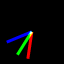

[INFO  11:14:39] [string "..."]:47: step=1, q=70.076, r=-0.30, a=-1.00	


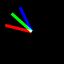

[INFO  11:14:40] [string "..."]:47: step=2, q=71.125, r=0.69, a=-0.07	


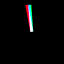

[INFO  11:14:40] [string "..."]:47: step=3, q=71.438, r=2.09, a=0.41	


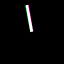

[INFO  11:14:40] [string "..."]:47: step=4, q=71.813, r=2.17, a=-0.22	


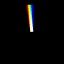

[INFO  11:14:40] [string "..."]:47: step=5, q=71.803, r=2.92, a=-0.12	


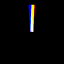

[INFO  11:14:40] [string "..."]:47: step=6, q=72.094, r=2.85, a=0.27	


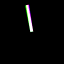

[INFO  11:14:40] [string "..."]:47: step=7, q=72.162, r=2.12, a=-0.31	


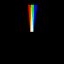

[INFO  11:14:40] [string "..."]:47: step=8, q=71.845, r=2.92, a=-0.10	


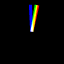

[INFO  11:14:40] [string "..."]:47: step=9, q=71.499, r=2.01, a=0.56	


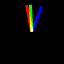

[INFO  11:14:40] [string "..."]:47: step=10, q=71.924, r=1.10, a=-1.00	


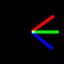

[INFO  11:14:41] [string "..."]:47: step=11, q=70.102, r=0.40, a=0.19	


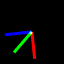

[INFO  11:14:41] [string "..."]:47: step=12, q=70.329, r=0.16, a=-0.17	


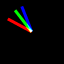

[INFO  11:14:41] [string "..."]:47: step=13, q=70.765, r=0.72, a=0.12	


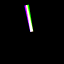

[INFO  11:14:41] [string "..."]:47: step=14, q=71.613, r=1.47, a=0.27	


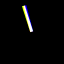

[INFO  11:14:41] [string "..."]:47: step=15, q=71.243, r=0.73, a=-0.36	


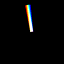

[INFO  11:14:41] [string "..."]:47: step=16, q=71.838, r=2.27, a=-0.04	


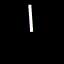

[INFO  11:14:41] [string "..."]:47: step=17, q=72.006, r=2.97, a=0.02	


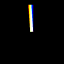

[INFO  11:14:41] [string "..."]:47: step=18, q=72.135, r=2.93, a=-0.12	


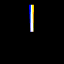

[INFO  11:14:41] [string "..."]:47: step=19, q=72.287, r=2.90, a=0.18	


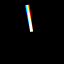

[INFO  11:14:41] [string "..."]:47: step=20, q=72.443, r=1.54, a=-0.15	


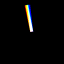

[INFO  11:14:42] [string "..."]:47: step=21, q=71.787, r=1.51, a=-0.21	


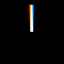

[INFO  11:14:42] [string "..."]:47: step=22, q=71.945, r=2.97, a=0.04	


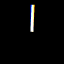

[INFO  11:14:42] [string "..."]:47: step=23, q=72.343, r=2.93, a=0.11	


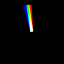

[INFO  11:14:42] [string "..."]:47: step=24, q=72.410, r=2.26, a=0.05	


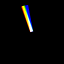

[INFO  11:14:42] [string "..."]:47: step=25, q=71.184, r=0.66, a=-0.51	


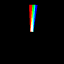

[INFO  11:14:42] [string "..."]:47: step=26, q=72.158, r=2.91, a=0.11	


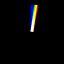

[INFO  11:14:42] [string "..."]:47: step=27, q=72.117, r=2.12, a=0.35	


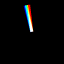

[INFO  11:14:42] [string "..."]:47: step=28, q=72.090, r=1.50, a=-0.22	


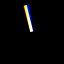

[INFO  11:14:42] [string "..."]:47: step=29, q=71.758, r=1.47, a=-0.25	


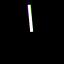

[INFO  11:14:42] [string "..."]:47: step=30, q=71.986, r=2.92, a=0.10	


In [25]:
_ = test(true)